In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# ① Imports & Load
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


plt.rcParams['figure.figsize'] = (8, 5)
sns.set(style="whitegrid")

train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test  = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

**Step 1：整体结构 & 基本信息**

In [3]:
# 看维度、前几行数据
print(train.shape)
train.head()

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# 看每列的数据类型 & 缺失数量
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
# 数值特征的基本统计
num_cols = ['Age', 'RoomService', 'FoodCourt', 
            'ShoppingMall', 'Spa', 'VRDeck']

train[num_cols].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


**Step 2：目标变量 Transported 的分布**

In [6]:
# 看正负样本是否平衡
train['Transported'].value_counts(normalize=True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

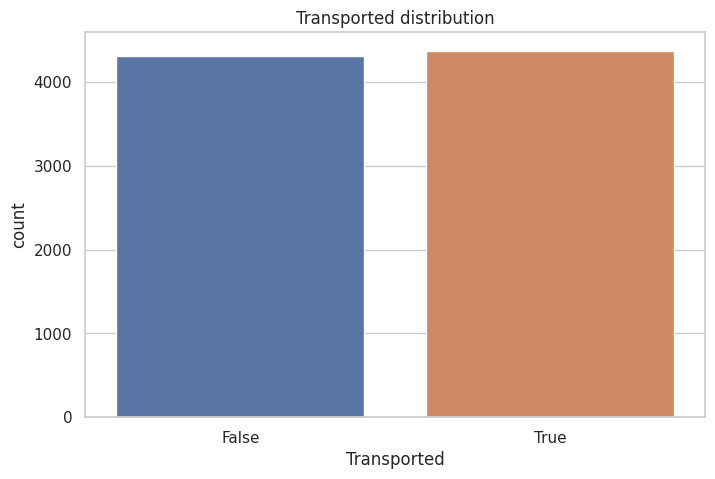

In [7]:
sns.countplot(data=train, x='Transported')
plt.title("Transported distribution")
plt.show()

**Step 3：缺失值分析（整体 & 按列）**

In [8]:
# 统计每列缺失比例
missing = train.isna().mean().sort_values(ascending=False)
missing

CryoSleep       0.024963
ShoppingMall    0.023927
VIP             0.023352
HomePlanet      0.023122
Name            0.023007
Cabin           0.022892
VRDeck          0.021627
FoodCourt       0.021051
Spa             0.021051
Destination     0.020936
RoomService     0.020821
Age             0.020591
PassengerId     0.000000
Transported     0.000000
dtype: float64

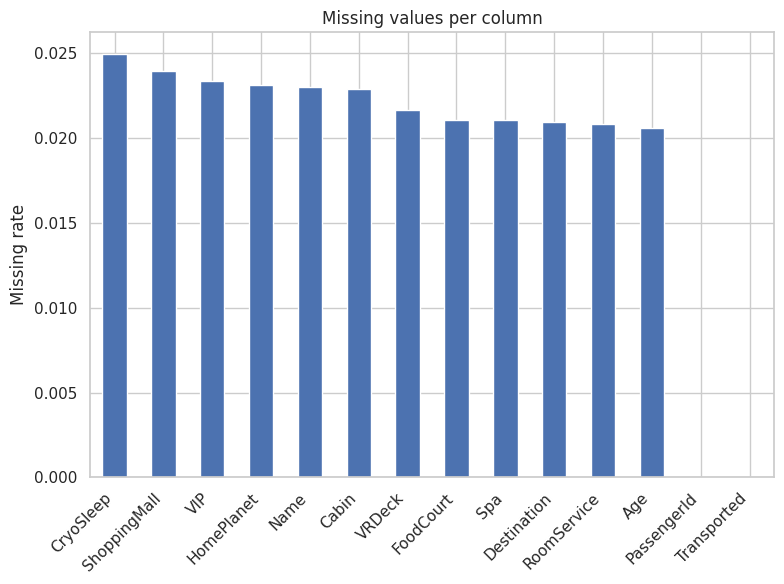

In [9]:
plt.figure(figsize=(8, 6))
missing.plot(kind='bar')
plt.ylabel("Missing rate")
plt.title("Missing values per column")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# 专门看消费列的缺失情况
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train[spend_cols].isna().mean()

RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
dtype: float64

**Step 4：单变量分布（数值特征）**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


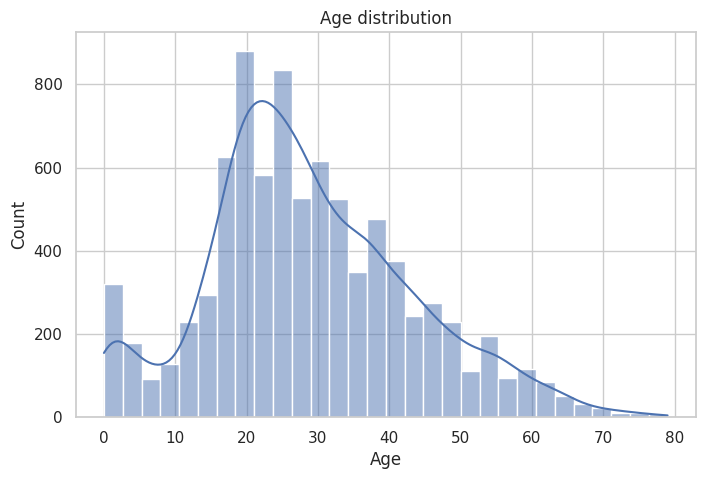

In [11]:
# Age 的分布
plt.figure()
sns.histplot(train['Age'], bins=30, kde=True)
plt.title("Age distribution")
plt.show()

In [12]:
# 总消费 TotalSpent 的分布
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# 不在这里填缺失，简单跳 NaN 即可
train['TotalSpent'] = train[spend_cols].sum(axis=1)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


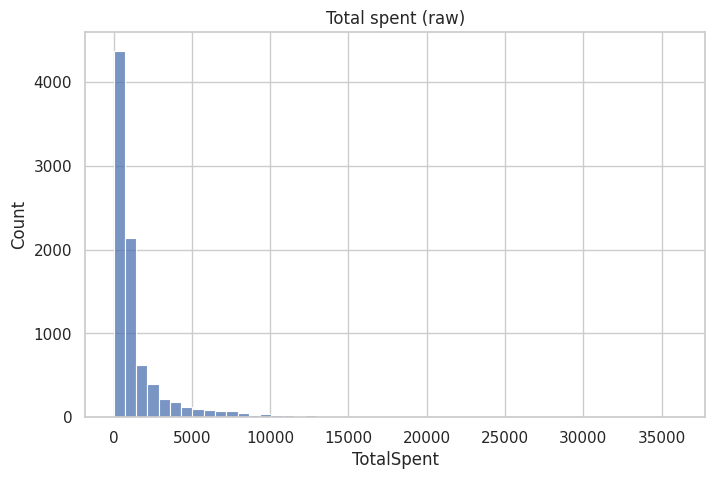

In [13]:
plt.figure()
sns.histplot(train['TotalSpent'], bins=50)
plt.title("Total spent (raw)")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


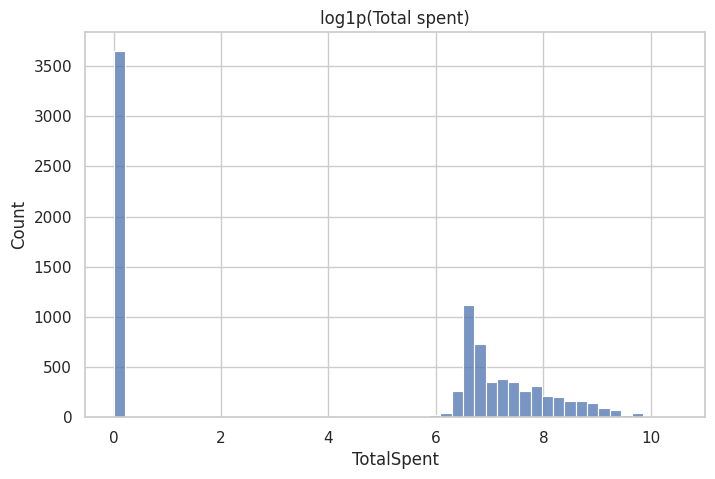

In [14]:
# 大部分人消费很低或 0；少数人消费非常高 → 右偏、长尾分布。

# 进行log1p 变换
plt.figure()
sns.histplot(np.log1p(train['TotalSpent']), bins=50)
plt.title("log1p(Total spent)")
plt.show()

**Step 5：重点特征与标签的关系（分类变量）**

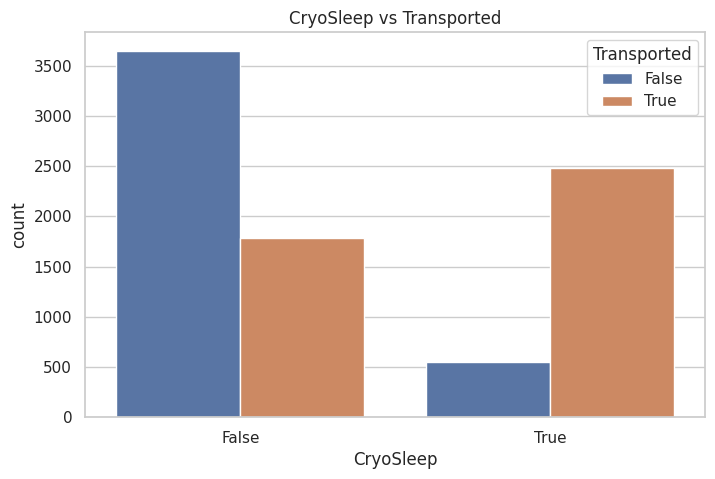

In [15]:
# CryoSleep vs Transported
sns.countplot(data=train, x='CryoSleep', hue='Transported')
plt.title("CryoSleep vs Transported")
plt.show()

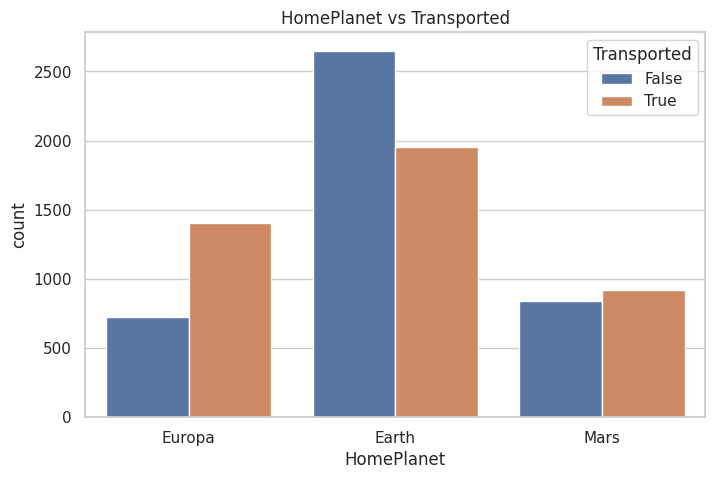

In [16]:
# HomePlanet vs Transported
sns.countplot(data=train, x='HomePlanet', hue='Transported')
plt.title("HomePlanet vs Transported")
plt.show()

In [17]:
# 标签：Transported（True/False）
y = train["Transported"].astype(int)   # True/False -> 1/0

# 1.2 baseline 使用的特征列
num_features = ["Age", 
                "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

cat_features = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

feature_cols = num_features + cat_features

# 1.3 从 train/test 中取出这些列
X = train[feature_cols].copy()
X_test = test[feature_cols].copy()

X.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,CryoSleep,Destination,VIP
0,39.0,0.0,0.0,0.0,0.0,0.0,Europa,False,TRAPPIST-1e,False
1,24.0,109.0,9.0,25.0,549.0,44.0,Earth,False,TRAPPIST-1e,False
2,58.0,43.0,3576.0,0.0,6715.0,49.0,Europa,False,TRAPPIST-1e,True
3,33.0,0.0,1283.0,371.0,3329.0,193.0,Europa,False,TRAPPIST-1e,False
4,16.0,303.0,70.0,151.0,565.0,2.0,Earth,False,TRAPPIST-1e,False


In [18]:
#缺失值处理 + One-Hot 编码（用 ColumnTransformer 打包）
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# 数值列的预处理：用中位数填充缺失
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# 类别列的预处理：
#   - 缺失用最频繁的类别填充（most_frequent）
#   - 然后做 One-Hot 编码
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# 把两类预处理合在一起
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

In [19]:
# 划分训练集 / 验证集（hold-out 验证）
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,          # 20% 做验证
    random_state=42,
    stratify=y              # 按标签分层，保持正负样本比例
)

X_train.shape, X_valid.shape

((6954, 10), (1739, 10))

In [20]:
# 搭建 Logistic Regression baseline
from sklearn.linear_model import LogisticRegression

# 把预处理器和模型放到一个 Pipeline 中
log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,      # 迭代次数多给一点，避免不收敛
        n_jobs=-1           # 用所有CPU核
    ))
])

# 训练
log_reg_clf.fit(X_train, y_train)

# 在验证集上预测
y_valid_pred = log_reg_clf.predict(X_valid)

# 评价准确率
val_acc = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy (Logistic Regression): {val_acc:.4f}")

Validation Accuracy (Logistic Regression): 0.7872


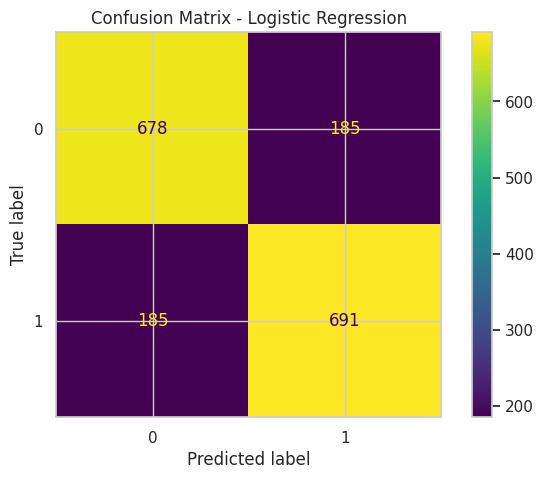

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       863
           1       0.79      0.79      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [21]:
# 混淆矩阵 & 分类报告（理解错在哪）
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_valid, y_valid_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print(classification_report(y_valid, y_valid_pred))

In [22]:
# 在全量 train 上训练，并对 test 生成第一版 submission
# 用全部训练数据重新训练模型
log_reg_clf_full = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    ))
])

log_reg_clf_full.fit(X, y)

# 对 test 数据预测（得到 0/1）
test_pred = log_reg_clf_full.predict(X_test)

# Kaggle 需要 True/False，所以把 0/1 转回布尔
test_pred_bool = test_pred.astype(bool)

# 生成 submission.csv
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Transported": test_pred_bool
})

submission.to_csv("submission_logreg_baseline.csv", index=False)
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
